In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import time
from ResNet import Bottleneck, ResNet, ResNet50
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist
import os
import torch
from fairscale.optim.oss import OSS
from fairscale.nn.data_parallel import ShardedDataParallel as ShardedDDP
from trainer import Trainer
from visualizer import *
import numpy as np

num_classes = 10
import torchvision.models as models

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# Load CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             download=True,
                                             transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False,
                                            download=True,
                                            transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:


# model = ModelParallelResNet50()
# model = ResNet50(num_classes)
# model.to(device)
# Set number of GPUs
num_gpus = torch.cuda.device_count()

# Use data parallelism
if num_gpus > 1: #Run this for just Data Parallelism
    model = torch.nn.DataParallel(model) #With 1 GPU, this won't run

def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'

    # initialize the process group
    dist.init_process_group("gloo", rank=rank, world_size=world_size)

setup(rank=0, world_size=num_gpus)

In [5]:


# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [7]:
# process group init
rank = 0
world_size = num_gpus
# setup(rank, world_size)

# Problem statement
model_shard = ResNet50(num_classes).to(rank)
# dataloader = mySuperFastDataloader()
# loss_ln = myVeryRelevantLoss()
model_shard.to(device)

# optimizer specific arguments e.g. LR, momentum, etc...
base_optimizer_arguments = { "lr": 1e-4,
                           "momentum":0.9}

# Wrap a base optimizer into OSS
base_optimizer = torch.optim.SGD  # any pytorch compliant optimizer
optimizer = OSS(
    params=model_shard.parameters(),
    optim=base_optimizer,
    **base_optimizer_arguments)

#Set up a scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)
# Wrap the model into ShardedDDP, which will reduce gradients to the proper ranks
model_shard = ShardedDDP(model_shard, optimizer)


Resnet With Optimized sharding

In [8]:
# trainer
num_epochs = 2
trainer = Trainer(model=model_shard,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=train_dataloader,
                  validation_dataloader=test_dataloader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True,
                  sharding  = False)

# start training
training_losses, validation_losses, lr_rates, training_times = trainer.run_trainer()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

In [10]:
mean_training_time = np.mean(training_times)
print("The Avg Training Time for each epoch is "+ str(mean_training_time) + "s")

The Avg Training Time for each epoch is 73.41854059696198s


In [9]:
total_training_time = np.sum(training_times)
print("The total Training Time for the model is "+ str(total_training_time/60) + "mins")

The total Training Time for the model is 2.447284686565399mins


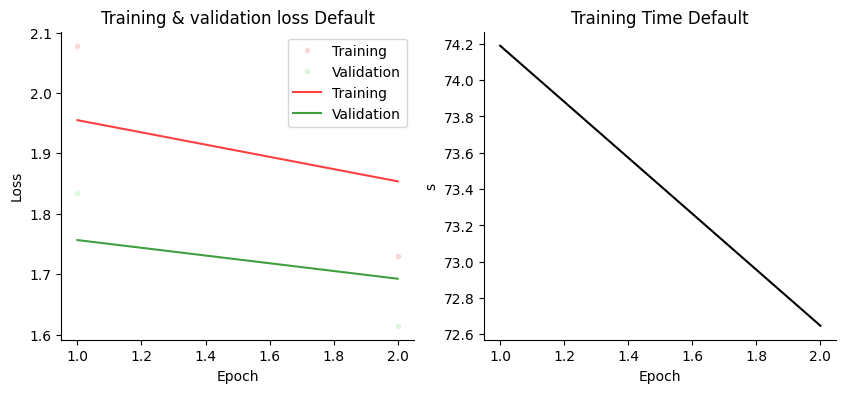

In [11]:
fig = plot_training(training_losses,
    validation_losses,
    training_times,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
)

In [12]:
# Model OSS
rank = 0
world_size = num_gpus
# setup(rank, world_size)

# Problem statement
model_oss = ResNet50(num_classes).to(rank)
# dataloader = mySuperFastDataloader()
# loss_ln = myVeryRelevantLoss()
model_oss.to(device)

# optimizer specific arguments e.g. LR, momentum, etc...
base_optimizer_arguments = { "lr": 1e-4,
                           "momentum":0.9}

# Wrap a base optimizer into OSS
base_optimizer = torch.optim.SGD  # any pytorch compliant optimizer
optimizer = OSS(
    params=model_oss.parameters(),
    optim=base_optimizer,
    **base_optimizer_arguments)

#Set up a scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [17]:
# trainer
num_epochs = 2
trainer = Trainer(model=model_oss,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_dataloader=train_dataloader,
                  validation_dataloader=test_dataloader,
                  lr_scheduler=None,
                  epochs=num_epochs,
                  epoch=0,
                  notebook=True,
                  sharding  = False)

# start training
training_losses_oss, validation_losses_oss, lr_rates_oss, training_times_oss = trainer.run_trainer()

Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/157 [00:00<?, ?it/s]

In [18]:
total_training_time = np.sum(training_times_oss)
print("The total Training Time for the model is "+ str(total_training_time/60) + "mins")

The total Training Time for the model is 1.523500418663025mins


In [19]:
mean_training_time = np.mean(training_times_oss)
print("The Avg Training Time for each epoch is "+ str(mean_training_time) + "s")

The Avg Training Time for each epoch is 45.70501255989075s


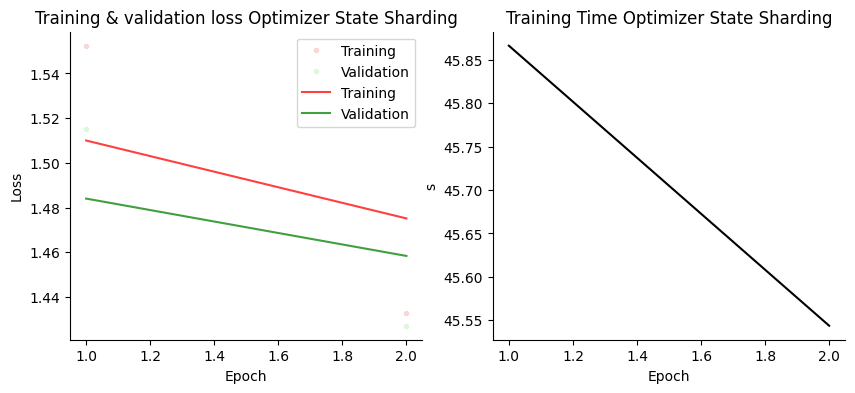

In [20]:
fig = plot_training(training_losses_oss,
    validation_losses_oss,
    training_times_oss,
    gaussian=True,
    sigma=1,
    figsize=(10, 4),
    setup = "Optimizer State Sharding"
)